<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 9.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=e77a07c041cc9b0af264dcfd818b5ff1bf657595c88be536f08a8a27ba4c9ad5
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate

In [68]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) * 10
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [69]:
dataset = create_samples(n_samples=1000)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,277000,0.82,227140.0
1,1000,2680950,0.82,2198379.0
2,1000,69190,0.82,56735.8
3,1000,3164360,0.82,2594775.2
4,1000,499720,0.82,409770.4
...,...,...,...,...
131526,1519,317590,0.32,101628.8
131527,1519,640090,0.32,204828.8
131528,1519,4993580,0.32,1597945.6
131529,1519,3480630,0.32,1113801.6


In [70]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max
CODE,int64,131531.0,0,1.258740e+03,1.519903e+02,1000.00,1121.00,1263.00,1391.00,1519.00
REAL_YY,int64,131531.0,0,2.498099e+06,2.199837e+06,70.00,675250.00,1866150.00,3824395.00,9980010.00
COM_RATE,float64,131531.0,0,5.166628e-01,2.839458e-01,0.01,0.27,0.53,0.76,0.99
NAFYC,float64,131531.0,0,1.286629e+06,1.473689e+06,3.00,211352.80,727637.40,1850434.95,9604871.10


In [71]:
dataset = dataset.astype({"CODE": object})

In [72]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,131531.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1074.0,496.0
REAL_YY,int64,131531.0,0,2.498099e+06,2.199837e+06,70.00,675250.00,1866150.00,3824395.00,9980010.00,NaN,NaN,NaN
COM_RATE,float64,131531.0,0,5.166628e-01,2.839458e-01,0.01,0.27,0.53,0.76,0.99,NaN,NaN,NaN
NAFYC,float64,131531.0,0,1.286629e+06,1.473689e+06,3.00,211352.80,727637.40,1850434.95,9604871.10,NaN,NaN,NaN


In [73]:
dataset[dataset['CODE'] == 1386]

,CODE,REAL_YY,COM_RATE,NAFYC
97196,1386,1924480,0.46,885260.8
97197,1386,3665970,0.46,1686346.2
97198,1386,7378600,0.46,3394156.0
97199,1386,5000,0.46,2300.0
97200,1386,2664660,0.46,1225743.6
...,...,...,...,...
97456,1386,2186180,0.46,1005642.8
97457,1386,4849320,0.46,2230687.2
97458,1386,1328580,0.46,611146.8
97459,1386,900150,0.46,414069.0


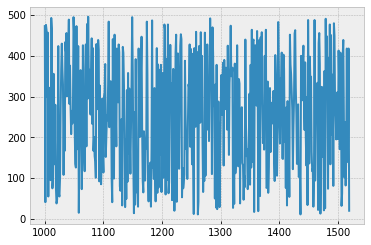

In [74]:
plt.plot(dataset.groupby('CODE')['CODE'].count())

In [75]:
# zscore norm

ds = dataset[['REAL_YY','COM_RATE']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,-1.009665,1.068292,227140.0
1,1000,0.083120,1.068292,2198379.0
2,1000,-1.104131,1.068292,56735.8
3,1000,0.302868,1.068292,2594775.2
4,1000,-0.908421,1.068292,409770.4
...,...,...,...,...
131526,1519,-0.991214,-0.692607,101628.8
131527,1519,-0.844612,-0.692607,204828.8
131528,1519,1.134393,-0.692607,1597945.6
131529,1519,0.446638,-0.692607,1113801.6


In [2]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [77]:
code_mapping = EmbeddingMapping(dataset['CODE'])
dataset = dataset.assign(code_mapping=dataset['CODE'].apply(code_mapping.get_mapping))
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,-1.009665,1.068292,227140.0,1
1,1000,0.083120,1.068292,2198379.0,1
2,1000,-1.104131,1.068292,56735.8,1
3,1000,0.302868,1.068292,2594775.2,1
4,1000,-0.908421,1.068292,409770.4,1
...,...,...,...,...,...
131526,1519,-0.991214,-0.692607,101628.8,520
131527,1519,-0.844612,-0.692607,204828.8,520
131528,1519,1.134393,-0.692607,1597945.6,520
131529,1519,0.446638,-0.692607,1113801.6,520


In [78]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY']]
X_val_categorical = X_val_org[['code_mapping']]


In [79]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

epochs = 500

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_3/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 64)        33344       input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 64)           0           embedding_3[0][0]                
_____________________

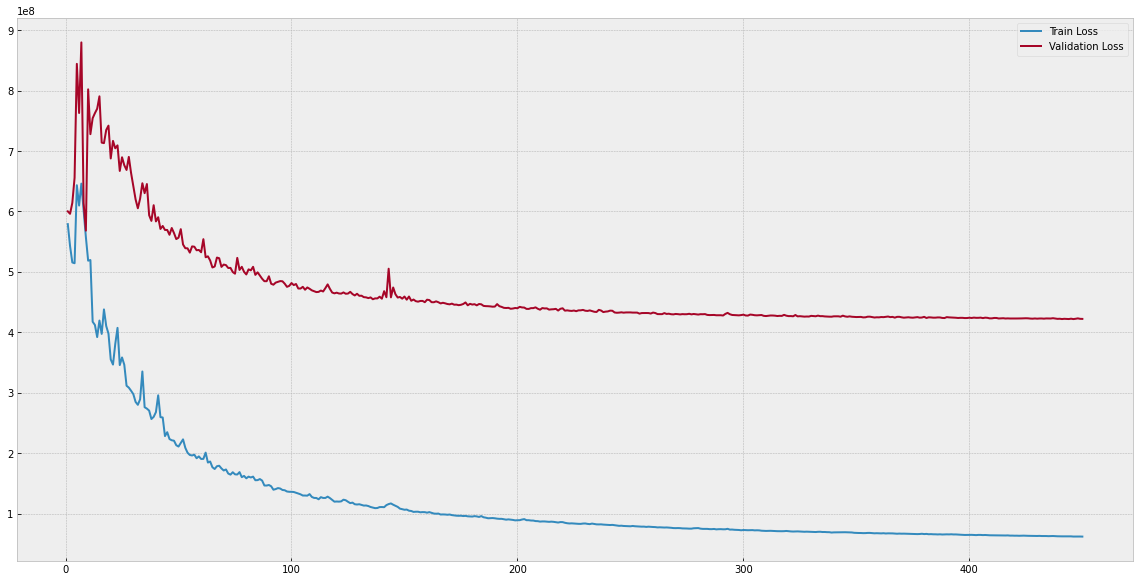

In [80]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][50:]
_val_loss = history.history['val_loss'][50:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1296053
The mean is very close to 0 (-81.36) with std. 20550.31.


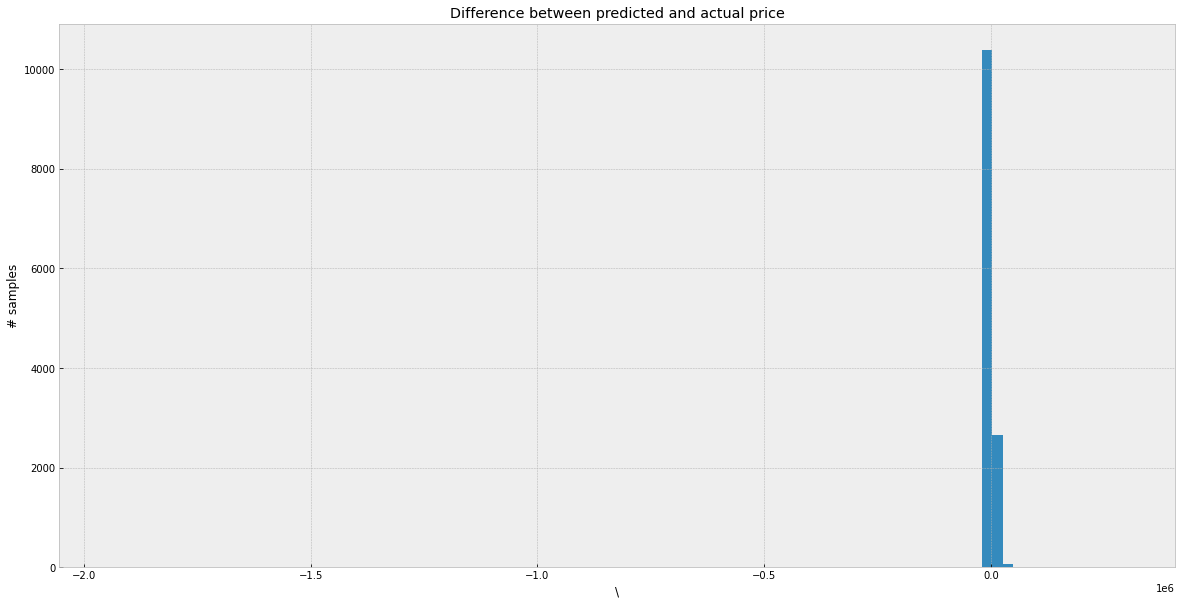

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
118796,1.194757e+05,-1.942812e+06,1.942812e+06,-94.206644,94.206644,1470,1.542910,-0.586953,2062287.5,471
118794,1.057950e+01,-1.018314e+06,1.018314e+06,-99.998961,99.998961,1470,0.187014,-0.586953,1018325.0,471
82257,6.743394e+06,2.945203e+05,2.945203e+05,4.567004,4.567004,1323,3.306118,0.504805,6448873.2,324
5231,1.240174e+06,2.744624e+05,2.744624e+05,28.420727,28.420727,1019,2.855257,-1.432184,965712.0,20
117511,2.598517e+05,1.777333e+05,1.777333e+05,216.435400,216.435400,1466,-1.096699,1.561344,82118.4,467
19846,2.253966e+06,1.326737e+05,1.326737e+05,6.254379,6.254379,1073,3.247577,-1.044787,2121292.8,74
19734,2.190556e+06,1.036888e+05,1.036888e+05,4.968634,4.968634,1073,3.176445,-1.044787,2086867.2,74
117506,3.543662e+05,9.309262e+04,9.309262e+04,35.630320,35.630320,1466,-1.011865,1.561344,261273.6,467
26802,6.124080e+06,8.485270e+04,8.485270e+04,1.405026,1.405026,1098,3.292330,0.363933,6039227.8,99
4083,7.761170e+06,7.047870e+04,7.047870e+04,0.916416,0.916416,1013,3.180499,1.033074,7690690.8,14


In [81]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [82]:
dataset[dataset['code_mapping']==3]

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
514,1002,-1.013575,0.540023,179828.0,3
515,1002,-0.146820,0.540023,1457330.4,3
516,1002,0.142934,0.540023,1884395.1,3
517,1002,-0.912467,0.540023,328849.4,3
518,1002,-0.984513,0.540023,222661.1,3
...,...,...,...,...,...
985,1002,0.326925,0.540023,2155577.6,3
986,1002,1.360897,0.540023,3679539.5,3
987,1002,-0.780876,0.540023,522801.0,3
988,1002,-1.072579,0.540023,92862.0,3


In [83]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,-1.009665,1.068292,227140.0,1
1,1000,0.083120,1.068292,2198379.0,1
2,1000,-1.104131,1.068292,56735.8,1
3,1000,0.302868,1.068292,2594775.2,1
4,1000,-0.908421,1.068292,409770.4,1
...,...,...,...,...,...
131526,1519,-0.991214,-0.692607,101628.8,520
131527,1519,-0.844612,-0.692607,204828.8,520
131528,1519,1.134393,-0.692607,1597945.6,520
131529,1519,0.446638,-0.692607,1113801.6,520


In [84]:
dataset['ft1'] = dataset['REAL_YY']* dataset['COM_RATE']

In [85]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
0,1000,-1.009665,1.068292,227140.0,1,-1.078618
1,1000,0.083120,1.068292,2198379.0,1,0.088797
2,1000,-1.104131,1.068292,56735.8,1,-1.179535
3,1000,0.302868,1.068292,2594775.2,1,0.323552
4,1000,-0.908421,1.068292,409770.4,1,-0.970460
...,...,...,...,...,...,...
131526,1519,-0.991214,-0.692607,101628.8,520,0.686522
131527,1519,-0.844612,-0.692607,204828.8,520,0.584984
131528,1519,1.134393,-0.692607,1597945.6,520,-0.785689
131529,1519,0.446638,-0.692607,1113801.6,520,-0.309344


In [86]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping']]


In [88]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

epochs = 500

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_5/concat:0", shape=(None, 66), dtype=float32)
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 64)        33344       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 64)           0           embedding_5[0][0]                
____________________

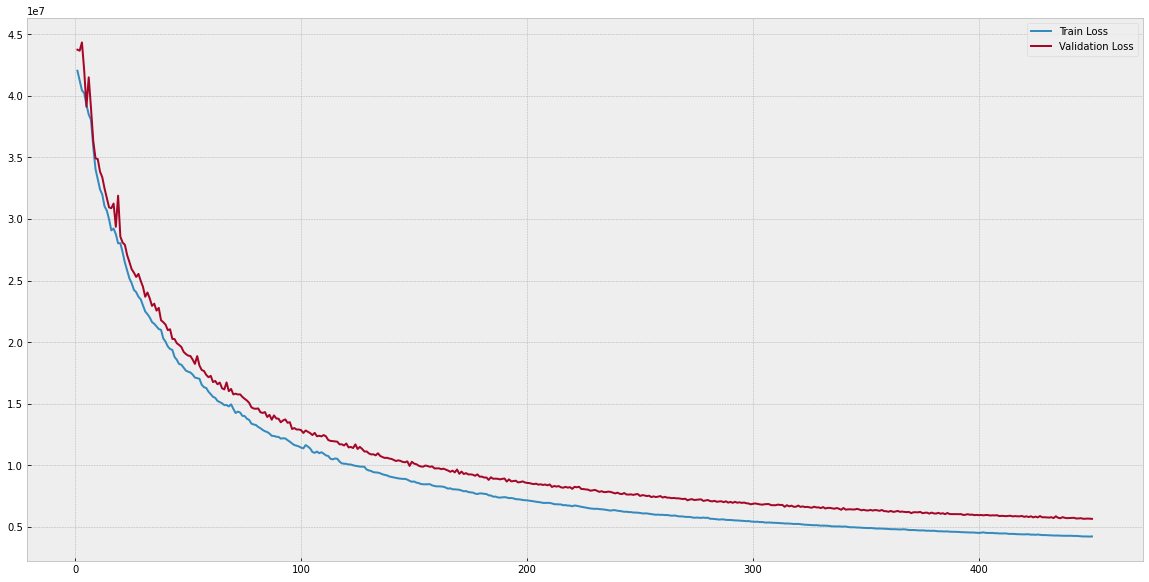

In [89]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][50:]
_val_loss = history.history['val_loss'][50:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

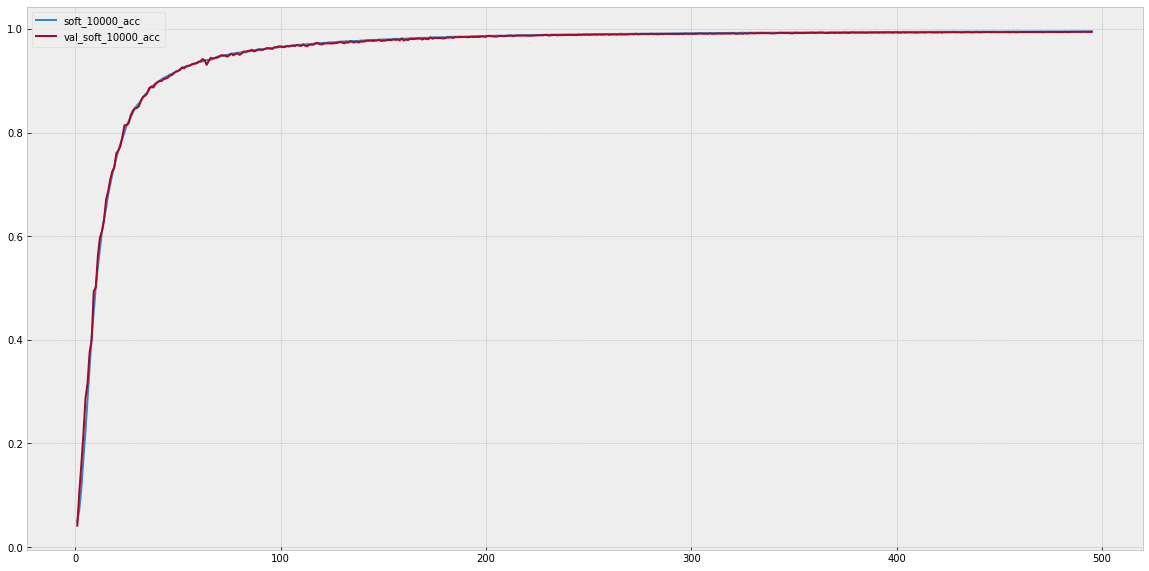

In [92]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1296053
The mean is very close to 0 (66.85) with std. 2373.3.


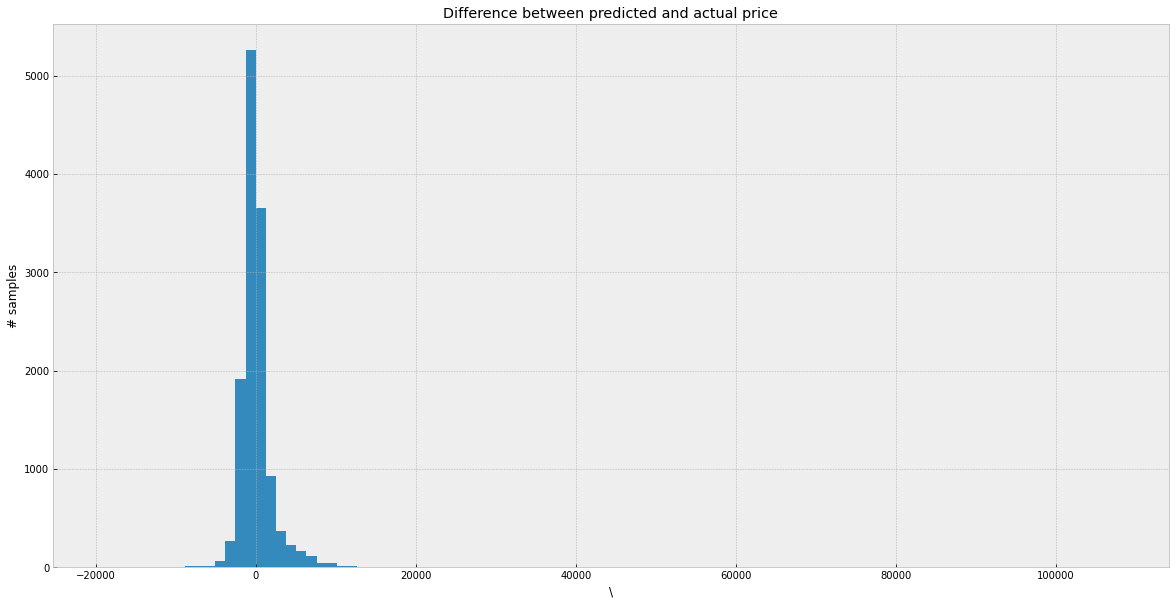

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
118796,2.170105e+06,107817.500000,107817.500000,5.228054,5.228054,1470,1.542910,-0.586953,2062287.5,471,-0.905616
117511,1.469957e+05,64877.271875,64877.271875,79.004549,79.004549,1466,-1.096699,1.561344,82118.4,467,-1.712325
38573,3.812877e+06,38505.250000,38505.250000,1.020176,1.020176,1145,2.949537,-0.340427,3774372.0,146,-1.004102
82257,6.478620e+06,29746.800000,29746.800000,0.461271,0.461271,1323,3.306118,0.504805,6448873.2,324,1.668943
4100,2.927080e+04,25091.196875,25091.196875,600.325315,600.325315,1013,-1.133238,1.033074,4179.6,14,-1.170719
5231,9.887431e+05,23031.125000,23031.125000,2.384885,2.384885,1019,2.855257,-1.432184,965712.0,20,-4.089255
57554,3.640510e+06,20080.950000,20080.950000,0.554657,0.554657,1230,2.366057,-0.164337,3620428.8,231,-0.388831
125552,3.942043e+06,19794.050000,19794.050000,0.504661,0.504661,1495,2.657974,-0.164337,3922248.7,496,-0.436804
104757,5.979733e+06,19349.800000,19349.800000,0.324640,0.324640,1416,3.306163,0.328715,5960383.2,417,1.086784
97443,4.035461e+06,19343.350000,19343.350000,0.481643,0.481643,1386,2.833206,-0.199555,4016117.4,387,-0.565381


In [93]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [94]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['NAFYC'],
    mode="regression"
)

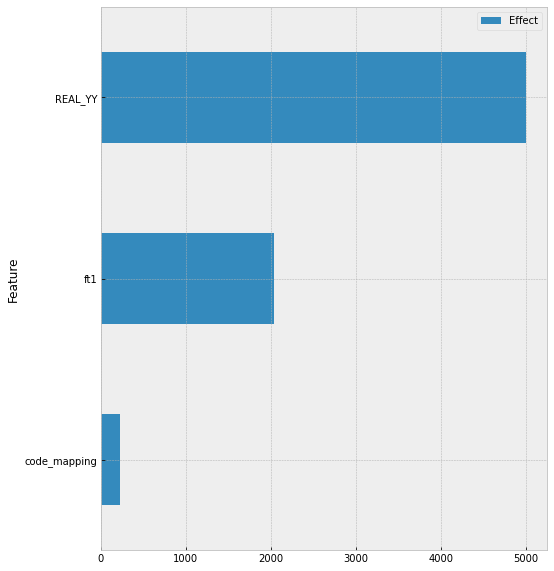

,Feature,Effect
0,code_mapping,225.448555
1,ft1,2036.297307
2,REAL_YY,4998.574576


In [95]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 10),kind='barh')
plt.show()
effect_result_table

## 시뮬레이션 데이터 생성

In [119]:
contract_change_rules = {
    '성립': 0,
    '실효': -0.4,
    '해약': -0.8,
    '철회': -0.5,
    '변경': -0.1
}

def create_samples2():
    rate_table = {}
    samples = []
    start_date = datetime.date(2015, 1, 1)
    end_date = datetime.date(2020, 8, 8)

    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,250))
      for j in range(count):
        cntr_no = str(random.choice(range(100000,500000))) + ':' + str(random.choice(range(100000,500000)))
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]

        div = '성립'
        minus_rate = 0

        # 계약일 생성
        time_between_dates = end_date - start_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        contract_date = start_date + datetime.timedelta(days=random_number_of_days)
        event_date = contract_date
        # 계약 총개월수 생성 
        contract_months = np.random.choice(range(12,12*30))
        event_num = 0
        samples.append([cntr_no,div,event_num,minus_rate,contract_date,contract_months,event_date,code,real_yy,rate])
        for changes in range(19):
          event_num += 1
          div = random.choice(['실효','해약','철회','변경'])
          # Event 발생일 생성 
          time_between_dates = end_date - event_date
          days_between_dates = time_between_dates.days
          random_number_of_days = random.randrange(days_between_dates)
          event_date = event_date + datetime.timedelta(days=random_number_of_days)
          if div=='변경':
            contract_date = event_date
            code = np.random.choice(range(1000,1520))
            real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
            contract_months = np.random.choice(range(12,12*30))       
            if code not in rate_table:
              rate = np.random.choice(range(1,100)) / 100
              rate_table[code] = rate
            else:
              rate = rate_table[code]
          elif div=='해약':
            samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
            break

          samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CONTRACT_ID','DIV','EVENT_NUM','MINUS_RATE','CONTRACT_DATE','CONTRACT_MONTHS','EVENT_DATE','CODE','REAL_YY','COM_RATE'])

In [120]:
dataset2 = create_samples2()

In [121]:
dataset2.head(10)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE
0,408275:159739,성립,0,0.0,2016-12-11,207,2016-12-11,1000,192465,0.05
1,408275:159739,실효,1,-0.4,2016-12-11,207,2016-12-23,1000,192465,0.05
2,408275:159739,실효,2,-0.4,2016-12-11,207,2019-12-21,1000,192465,0.05
3,408275:159739,해약,3,-0.8,2016-12-11,207,2020-06-08,1000,192465,0.05
4,376945:458998,성립,0,0.0,2017-04-27,198,2017-04-27,1000,239568,0.05
5,376945:458998,변경,1,-0.1,2020-03-02,341,2020-03-02,1092,378486,0.26
6,376945:458998,해약,2,-0.8,2020-03-02,341,2020-07-31,1092,378486,0.26
7,286167:166792,성립,0,0.0,2015-04-23,33,2015-04-23,1092,21376,0.26
8,286167:166792,변경,1,-0.1,2019-03-21,306,2019-03-21,1450,49680,0.89
9,286167:166792,철회,2,-0.5,2019-03-21,306,2019-06-25,1450,49680,0.89


In [122]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [123]:
back_nafyc = {}

def nafyc_func2(row):
  CONTRACT_ID = row['CONTRACT_ID']
  DIV = row['DIV']
  MINUS_RATE = row['MINUS_RATE']
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  CODE = row['CODE']
  REAL_YY = row['REAL_YY']
  COM_RATE = row['COM_RATE']
  if DIV=='성립':
    nafyc = REAL_YY * COM_RATE
    back_nafyc[CONTRACT_ID] = nafyc
  else:
    nafyc = back_nafyc[CONTRACT_ID]
    # event가 발생하면 nafyc = nafyc + nafyc * (남은기간/전체기간 * 마이너스비율)
    nafyc = nafyc + nafyc * MINUS_RATE * ((diff_month(EVENT_DATE,CONTRACT_DATE))/CONTRACT_MONTHS)
    back_nafyc[CONTRACT_ID] = nafyc

  return nafyc

In [124]:
dataset2['NAFYC'] = dataset2.apply(nafyc_func2, axis=1)

In [125]:
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC
0,408275:159739,성립,0,0.0,2016-12-11,207,2016-12-11,1000,192465,0.05,9623.250000
1,408275:159739,실효,1,-0.4,2016-12-11,207,2016-12-23,1000,192465,0.05,9623.250000
2,408275:159739,실효,2,-0.4,2016-12-11,207,2019-12-21,1000,192465,0.05,8953.806522
3,408275:159739,해약,3,-0.8,2016-12-11,207,2020-06-08,1000,192465,0.05,7500.435028
4,376945:458998,성립,0,0.0,2017-04-27,198,2017-04-27,1000,239568,0.05,11978.400000
...,...,...,...,...,...,...,...,...,...,...,...
348303,194947:294541,성립,0,0.0,2017-12-23,195,2017-12-23,1007,449865,0.79,355393.350000
348304,194947:294541,변경,1,-0.1,2019-03-09,167,2019-03-09,1454,6808,0.71,355393.350000
348305,194947:294541,철회,2,-0.5,2019-03-09,167,2020-02-09,1454,6808,0.71,343688.778593
348306,194947:294541,철회,3,-0.5,2019-03-09,167,2020-06-08,1454,6808,0.71,328253.653806


## EDA 과정

In [126]:
dataset2.groupby('CONTRACT_ID').count().max()

DIV                20
EVENT_NUM          20
MINUS_RATE         20
CONTRACT_DATE      20
CONTRACT_MONTHS    20
EVENT_DATE         20
CODE               20
REAL_YY            20
COM_RATE           20
NAFYC              20
dtype: int64

## 데이터 전처리...

In [127]:
dataset2 = dataset2.astype({"CODE": object})

In [128]:
structure(dataset2)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CONTRACT_ID,object,348308,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69812,283989:162594,20
DIV,object,348308,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,실효,69844
EVENT_NUM,int64,348308,0,3.13987,3.29675,0,1,2,5,19,NaN,NaN,NaN
MINUS_RATE,float64,348308,0,-0.359769,0.286961,-0.8,-0.5,-0.4,-0.1,0,NaN,NaN,NaN
CONTRACT_DATE,object,348308,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,30327
CONTRACT_MONTHS,int64,348308,0,185.382,100.421,12,98,185,272,359,NaN,NaN,NaN
EVENT_DATE,object,348308,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,49290
CODE,object,348308,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520,1281,948
REAL_YY,int64,348308,0,250200,220401,2,67135.2,187099,382992,995006,NaN,NaN,NaN
COM_RATE,float64,348308,0,0.479661,0.295297,0.01,0.22,0.46,0.75,0.99,NaN,NaN,NaN


In [129]:
def last_months(row):
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  return CONTRACT_MONTHS - diff_month(EVENT_DATE,CONTRACT_DATE)


In [130]:
dataset2['LAST_MONTHS'] = dataset2.apply(last_months, axis=1)
dataset2['ft1'] = dataset2['REAL_YY']* dataset2['COM_RATE']
dataset2['ft2'] = dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']


In [131]:
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,LAST_MONTHS,ft1,ft2
0,408275:159739,성립,0,0.0,2016-12-11,207,2016-12-11,1000,192465,0.05,9623.250000,207,9623.25,1.000000
1,408275:159739,실효,1,-0.4,2016-12-11,207,2016-12-23,1000,192465,0.05,9623.250000,207,9623.25,1.000000
2,408275:159739,실효,2,-0.4,2016-12-11,207,2019-12-21,1000,192465,0.05,8953.806522,171,9623.25,0.826087
3,408275:159739,해약,3,-0.8,2016-12-11,207,2020-06-08,1000,192465,0.05,7500.435028,165,9623.25,0.797101
4,376945:458998,성립,0,0.0,2017-04-27,198,2017-04-27,1000,239568,0.05,11978.400000,198,11978.40,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348303,194947:294541,성립,0,0.0,2017-12-23,195,2017-12-23,1007,449865,0.79,355393.350000,195,355393.35,1.000000
348304,194947:294541,변경,1,-0.1,2019-03-09,167,2019-03-09,1454,6808,0.71,355393.350000,167,4833.68,1.000000
348305,194947:294541,철회,2,-0.5,2019-03-09,167,2020-02-09,1454,6808,0.71,343688.778593,156,4833.68,0.934132
348306,194947:294541,철회,3,-0.5,2019-03-09,167,2020-06-08,1454,6808,0.71,328253.653806,152,4833.68,0.910180


In [132]:
# zscore norm

ds = dataset2[['MINUS_RATE','CONTRACT_MONTHS','REAL_YY','COM_RATE','LAST_MONTHS','ft1','ft2']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset2.update(ds)
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,LAST_MONTHS,ft1,ft2
0,408275:159739,성립,0,1.253719,2016-12-11,0.215277,2016-12-11,1000,-0.261956,-1.455016,9623.250000,0.293053,-0.765745,0.334525
1,408275:159739,실효,1,-0.140198,2016-12-11,0.215277,2016-12-23,1000,-0.261956,-1.455016,9623.250000,0.293053,-0.765745,0.334525
2,408275:159739,실효,2,-0.140198,2016-12-11,0.215277,2019-12-21,1000,-0.261956,-1.455016,8953.806522,-0.061988,-0.765745,-0.397164
3,408275:159739,해약,3,-1.534115,2016-12-11,0.215277,2020-06-08,1000,-0.261956,-1.455016,7500.435028,-0.121162,-0.765745,-0.519112
4,376945:458998,성립,0,1.253719,2017-04-27,0.125655,2017-04-27,1000,-0.048241,-1.455016,11978.400000,0.204292,-0.749416,0.334525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348303,194947:294541,성립,0,1.253719,2017-12-23,0.095780,2017-12-23,1007,0.905916,1.050939,355393.350000,0.174706,1.631672,0.334525
348304,194947:294541,변경,1,0.905240,2019-03-09,-0.183045,2019-03-09,1454,-1.104316,0.780025,355393.350000,-0.101437,-0.798954,0.334525
348305,194947:294541,철회,2,-0.488677,2019-03-09,-0.183045,2020-02-09,1454,-1.104316,0.780025,343688.778593,-0.209922,-0.798954,0.057403
348306,194947:294541,철회,3,-0.488677,2019-03-09,-0.183045,2020-06-08,1454,-1.104316,0.780025,328253.653806,-0.249371,-0.798954,-0.043368


In [133]:
# 상품코드의 categpry mapping
code_mapping = EmbeddingMapping(dataset2['CODE'])
dataset2 = dataset2.assign(code_mapping=dataset2['CODE'].apply(code_mapping.get_mapping))
# event구분의 category mapping
div_mapping = EmbeddingMapping(dataset2['DIV'])
dataset2 = dataset2.assign(div_mapping=dataset2['DIV'].apply(div_mapping.get_mapping))

dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,LAST_MONTHS,ft1,ft2,code_mapping,div_mapping
0,408275:159739,성립,0,1.253719,2016-12-11,0.215277,2016-12-11,1000,-0.261956,-1.455016,9623.250000,0.293053,-0.765745,0.334525,1,1
1,408275:159739,실효,1,-0.140198,2016-12-11,0.215277,2016-12-23,1000,-0.261956,-1.455016,9623.250000,0.293053,-0.765745,0.334525,1,2
2,408275:159739,실효,2,-0.140198,2016-12-11,0.215277,2019-12-21,1000,-0.261956,-1.455016,8953.806522,-0.061988,-0.765745,-0.397164,1,2
3,408275:159739,해약,3,-1.534115,2016-12-11,0.215277,2020-06-08,1000,-0.261956,-1.455016,7500.435028,-0.121162,-0.765745,-0.519112,1,3
4,376945:458998,성립,0,1.253719,2017-04-27,0.125655,2017-04-27,1000,-0.048241,-1.455016,11978.400000,0.204292,-0.749416,0.334525,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348303,194947:294541,성립,0,1.253719,2017-12-23,0.095780,2017-12-23,1007,0.905916,1.050939,355393.350000,0.174706,1.631672,0.334525,366,1
348304,194947:294541,변경,1,0.905240,2019-03-09,-0.183045,2019-03-09,1454,-1.104316,0.780025,355393.350000,-0.101437,-0.798954,0.334525,382,4
348305,194947:294541,철회,2,-0.488677,2019-03-09,-0.183045,2020-02-09,1454,-1.104316,0.780025,343688.778593,-0.209922,-0.798954,0.057403,382,5
348306,194947:294541,철회,3,-0.488677,2019-03-09,-0.183045,2020-06-08,1454,-1.104316,0.780025,328253.653806,-0.249371,-0.798954,-0.043368,382,5


In [134]:
dataset_net = dataset2[['CONTRACT_ID','EVENT_NUM','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','code_mapping','div_mapping','NAFYC']]
dataset_net.shape

(348308, 10)

In [135]:
# 하나의 계약당 복수의 event들(1:N)을 하나의 학습셋으로 변환한다..

# 계약단위로 Group한다.
ds_net_group = dataset_net.groupby('CONTRACT_ID')
result = list(ds_net_group)
unique_contract_count = len(result)

# 하나의 계약에서 발생하는 최대 Event 개수를 취득
max_N = ds_net_group.count()['code_mapping'].max()
effect_columns = ['EVENT_NUM','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','code_mapping','div_mapping']
dataset_right = []
prgs = 0
for i in range(unique_contract_count):
  # 계약당 event 그룹의 추출
  ds_events = dataset_net.loc[result[i][1].index]
  for row in ds_events.iterrows():
    event_num = int(row[1][1])
    # 앞선 event의 effect_columns를 추출
    inner_set = ds_events[effect_columns][0:event_num].to_numpy()
    #  최대 Event 개수에 대한 padding 처리
    inner_set = np.append(inner_set,np.zeros((max_N-inner_set.shape[0],len(effect_columns))), axis=0)
    # 1:N 관계 형성
    dataset_right.append(inner_set)
    prgs +=1
    if prgs%100==0:
      print('\rProgress :{}/{}'.format(prgs,dataset_net.shape[0]),end="", flush=True)    

dataset_right = np.array(dataset_right)
dataset_right = dataset_right.reshape(dataset_net.shape[0],max_N*len(effect_columns))
print(dataset_right.shape)  
dataset_right = dataset_right.tolist()
dataset_net['EVENTS'] = dataset_right       

Progress :348300/348308(348308, 160)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Trainset과 Validationset의 분리  

In [136]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset_net[['CONTRACT_ID','EVENT_NUM','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','code_mapping','div_mapping','EVENTS']],
    dataset_net['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택

X_train_continuous = X_train_org[['EVENT_NUM','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2']]
X_train_categorical = X_train_org[['code_mapping','div_mapping']]
X_train_events = np.array(X_train_org['EVENTS'].tolist())
# event에서도 continuous 와 categorical을 분리...
X_train_events_continuous = X_train_events[:,[[0+i*8,1+i*8,2+i*8,3+i*8,4+i*8,5+i*8] for i in range(max_N)]].reshape(-1,max_N*6)
X_train_events_categorical = X_train_events[:,[[6+i*8,7+i*8] for i in range(max_N)]].reshape(-1,max_N*2)


X_val_continuous  = X_val_org[['EVENT_NUM','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2']]
X_val_categorical = X_val_org[['code_mapping','div_mapping']]
X_val_events = np.array(X_val_org['EVENTS'].tolist())
# event에서도 continuous 와 categorical을 분리...
X_val_events_continuous = X_val_events[:,[[0+i*8,1+i*8,2+i*8,3+i*8,4+i*8,5+i*8] for i in range(max_N)]].reshape(-1,max_N*6)
X_val_events_categorical = X_val_events[:,[[6+i*8,7+i*8] for i in range(max_N)]].reshape(-1,max_N*2)


In [137]:
X_val_events_categorical

array([[ 91.,   1.,   0., ...,   0.,   0.,   0.],
       [285.,   1.,   0., ...,   0.,   0.,   0.],
       [459.,   1.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 29.,   1.,  29., ...,   0.,   0.,   0.],
       [ 18.,   1.,   0., ...,   0.,   0.,   0.],
       [128.,   1., 128., ...,   0.,   0.,   0.]])

## Network의 구성

In [145]:
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Define the embedding input
code_input = Input(shape=(2,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*2,))(code_embedings)

event_continuous_input = Input(shape=(X_train_events_continuous.shape[1], ))

# Define the embedding input
event_code_input = Input(shape=(2*max_N,), dtype='int32') 
output_dim=16  #X_train_categorical['code_mapping'].max()*1
event_code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(event_code_input)
event_code_embedings = keras.layers.Reshape((output_dim*2*max_N,))(event_code_embedings)

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input,code_embedings,event_continuous_input,event_code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(100, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input,event_continuous_input, event_code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()


Tensor("concatenate_8/concat:0", shape=(None, 894), dtype=float32)
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 2, 64)        33344       input_34[0][0]                   
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 40, 16)       8336        input_36[0][0]                   
___________________

In [146]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical,X_train_events_continuous, X_train_events_categorical], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=1,
          validation_data=([X_val_continuous, X_val_categorical,X_val_events_continuous, X_val_events_categorical], Y_val))

Epoch 1/100
32/32 [==============================] - 2s 66ms/step - loss: 71402430464.0000 - soft_500_acc: 0.0220 - soft_1000_acc: 0.0371 - soft_10000_acc: 0.1889 - r2: -2.8976 - val_loss: 29434916864.0000 - val_soft_500_acc: 0.0244 - val_soft_1000_acc: 0.0415 - val_soft_10000_acc: 0.2014 - val_r2: -0.6425
Epoch 2/100
32/32 [==============================] - 2s 58ms/step - loss: 29346349056.0000 - soft_500_acc: 0.0239 - soft_1000_acc: 0.0400 - soft_10000_acc: 0.2004 - r2: -0.6454 - val_loss: 29431623680.0000 - val_soft_500_acc: 0.0249 - val_soft_1000_acc: 0.0420 - val_soft_10000_acc: 0.2015 - val_r2: -0.6423
Epoch 3/100
32/32 [==============================] - 2s 59ms/step - loss: 29342818304.0000 - soft_500_acc: 0.0248 - soft_1000_acc: 0.0406 - soft_10000_acc: 0.2006 - r2: -0.6463 - val_loss: 29427898368.0000 - val_soft_500_acc: 0.0258 - val_soft_1000_acc: 0.0425 - val_soft_10000_acc: 0.2017 - val_r2: -0.6421
Epoch 4/100
32/32 [==============================] - 2s 58ms/step - loss: 29

KeyboardInterrupt: ignored